1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?	블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.

2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?	tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.

3. Ablation Study 결과가 바른 포맷으로 제출되었는가?	ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

# ResNet Model 만들기

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def resnet_block(input_layer, filters, strides=1, is_50=False):
    """
    ResNet block with optional bottleneck.
    """
    first_kernel_size = 1 if is_50 else 3
    first_padding = 'valid' if is_50 else 'same'
    last_filters = filters * 4 if is_50 else filters

    x = layers.Conv2D(filters, first_kernel_size, strides=strides, padding=first_padding)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if is_50:
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(last_filters, 1)(x)
        x = layers.BatchNormalization()(x)

    # Residual connection
    shortcut = input_layer
    if strides > 1 or is_50:
        shortcut = layers.Conv2D(last_filters, 1, strides=strides, padding=first_padding)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)    

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_resnet(input_shape, num_classes, is_50=False):
    """
    Builds a ResNet model.
    """
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(3, strides=2, padding='same')(x)

    num_blocks_list = [3, 4, 6, 3]  # Number of blocks in each stage
    filters_list = [64, 128, 256, 512]

    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        filters = filters_list[i]
        strides = 2 if i > 0 else 1  # First block of each stage except the first has stride 2

        for j in range(num_blocks):
            x = resnet_block(x, filters, strides=strides if j == 0 else 1, is_50=is_50)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs=input_layer, outputs=outputs)


2023-12-27 14:35:32.555246: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-27 14:35:32.580416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 14:35:32.580434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 14:35:32.581128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 14:35:32.585424: I tensorflow/core/platform/cpu_feature_guar

# Plainnet Model 만들기

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def plainnet_block(input_layer, filters, strides=1, is_50=False):
    """
    ResNet block with optional bottleneck.
    """
    first_kernel_size = 1 if is_50 else 3
    first_padding = 'valid' if is_50 else 'same'
    last_filters = filters * 4 if is_50 else filters

    x = layers.Conv2D(filters, first_kernel_size, strides=strides, padding=first_padding)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if is_50:
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(last_filters, 1)(x)
        x = layers.BatchNormalization()(x)

    # Residual connection
    # shortcut = input_layer
    # if strides > 1 or is_50:
    #     shortcut = layers.Conv2D(last_filters, 1, strides=strides, padding=first_padding)(shortcut)
    #     shortcut = layers.BatchNormalization()(shortcut)    

    # x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_plainnet(input_shape, num_classes, is_50=False):
    """
    Builds a ResNet model.
    """
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(3, strides=2, padding='same')(x)

    num_blocks_list = [3, 4, 6, 3]  # Number of blocks in each stage
    filters_list = [64, 128, 256, 512]

    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        filters = filters_list[i]
        strides = 2 if i > 0 else 1  # First block of each stage except the first has stride 2

        for j in range(num_blocks):
            x = plainnet_block(x, filters, strides=strides if j == 0 else 1, is_50=is_50)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs=input_layer, outputs=outputs)


In [3]:
resnet_50 = build_resnet(input_shape=(32, 32,3), num_classes=10, is_50=True)
resnet_50.summary()

2023-12-27 14:35:34.143319: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 14:35:34.147527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 14:35:34.147552: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 14:35:34.151050: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 14:35:34.151077: I external/local_xla/xla/stream_executor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 16, 16, 64)           0         ['batch_normalization[0][0

In [4]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), num_classes=10, is_50=False)
resnet_34.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_65 (Conv2D)          (None, 16, 16, 64)           9472      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_65 (Ba  (None, 16, 16, 64)           256       ['conv2d_65[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_49 (Activation)  (None, 16, 16, 64)           0         ['batch_normalization_65

In [28]:
plainnet_34 = build_plainnet(input_shape=(224, 224, 3), num_classes=2, is_50=False)
plainnet_34.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_284 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_284 (B  (None, 112, 112, 64)      256       
 atchNormalization)                                              
                                                                 
 activation_246 (Activation  (None, 112, 112, 64)      0         
 )                                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                           

In [6]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), num_classes=2, is_50=False)
resnet_34.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_134 (Conv2D)         (None, 112, 112, 64)         9472      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_134 (B  (None, 112, 112, 64)         256       ['conv2d_134[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_115 (Activation  (None, 112, 112, 64)         0         ['batch_normalization_13

In [46]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), num_classes=2, is_50=True)
resnet_50.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_431 (Conv2D)         (None, 112, 112, 64)         9472      ['input_10[0][0]']            
                                                                                                  
 batch_normalization_431 (B  (None, 112, 112, 64)         256       ['conv2d_431[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_377 (Activation  (None, 112, 112, 64)         0         ['batch_normalization_43

resnet_34 = build_resnet(input_shape=(32, 32, 3), num_classes=10, is_50=False)
resnet_34.summary()

In [33]:
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), num_classes=2, is_50=True)
plainnet_50.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_317 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_317 (B  (None, 112, 112, 64)      256       
 atchNormalization)                                              
                                                                 
 activation_279 (Activation  (None, 112, 112, 64)      0         
 )                                                               
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                           

# 데이터 전처리

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
import os
from tensorflow.keras.utils import to_categorical

# 데이터셋 로드 및 전처리
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

In [10]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])  # 모든 이미지를 224x224로 리사이즈
    image = tf.cast(image, tf.float32) / 255.0  # 정규화
    return image, label

In [12]:


batch_size = 32  # 배치 크기 설정

ds_train = ds_train.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_validation = ds_validation.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess)


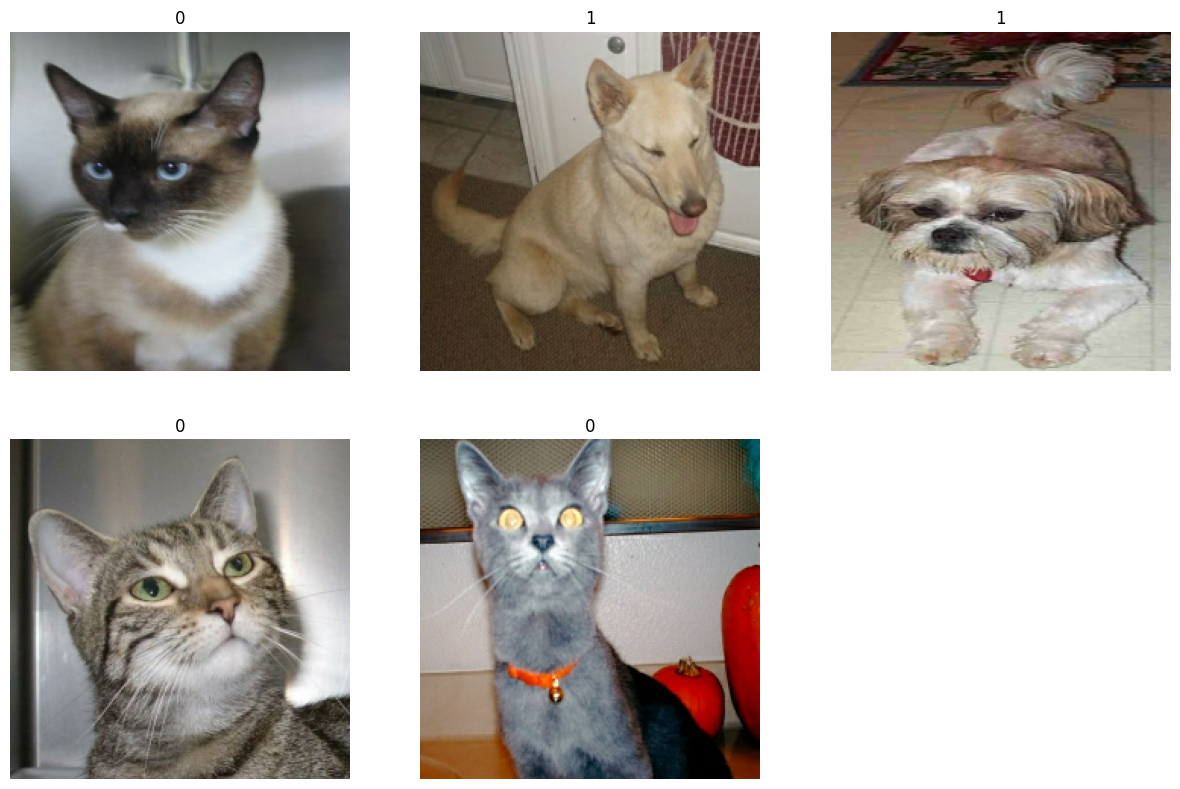

In [13]:

import matplotlib.pyplot as plt

def visualize_dataset(ds, num_samples=5):
    ds = ds.batch(num_samples)  # 배치 처리 추가
    plt.figure(figsize=(15, 15))

    for images, labels in ds.take(1):  # 첫 번째 배치 가져오기
        for i in range(num_samples):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(labels[i].numpy())
            plt.axis("off")

# 데이터셋 시각화
visualize_dataset(ds_test)


In [14]:

ds_test = ds_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [15]:
# from tensorflow.keras.utils import to_categorical

# def encode_labels(image, label):
#     return image, tf.one_hot(label, depth=2)

# ds_train = ds_train.map(encode_labels)
# ds_validation = ds_validation.map(encode_labels)
# ds_test = ds_test.map(encode_labels)

#  Ablation Study 시작

In [34]:


# ResNet 모델 생성
model = plainnet_50  # ResNet-34 생성
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 콜백 설정
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "plainnet_50.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 생성
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              monitor='val_loss',
                              verbose=1)

# 얼리 스탑핑 콜백 생성
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 모델 학습
history_plainnet_50=model.fit(ds_train,
          validation_data=ds_validation,
          epochs=10,
          callbacks=[early_stop, cp_callback, tensorboard_callback])

Epoch 1/10
582/582 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.5569
Epoch 1: val_loss improved from inf to 0.78970, saving model to plainnet_50.h5
582/582 [==============================] - 106s 147ms/step - loss: 0.7048 - accuracy: 0.5569 - val_loss: 0.7897 - val_accuracy: 0.5490
Epoch 2/10
582/582 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.6275
Epoch 2: val_loss improved from 0.78970 to 0.68457, saving model to plainnet_50.h5
582/582 [==============================] - 84s 144ms/step - loss: 0.6516 - accuracy: 0.6275 - val_loss: 0.6846 - val_accuracy: 0.5800
Epoch 3/10
582/582 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.6523
Epoch 3: val_loss improved from 0.68457 to 0.64818, saving model to plainnet_50.h5
582/582 [==============================] - 85s 146ms/step - loss: 0.6320 - accuracy: 0.6523 - val_loss: 0.6482 - val_accuracy: 0.6466
Epoch 4/10
582/582 [==============================] - ETA: 0s - 

#  훈련 결과 확인

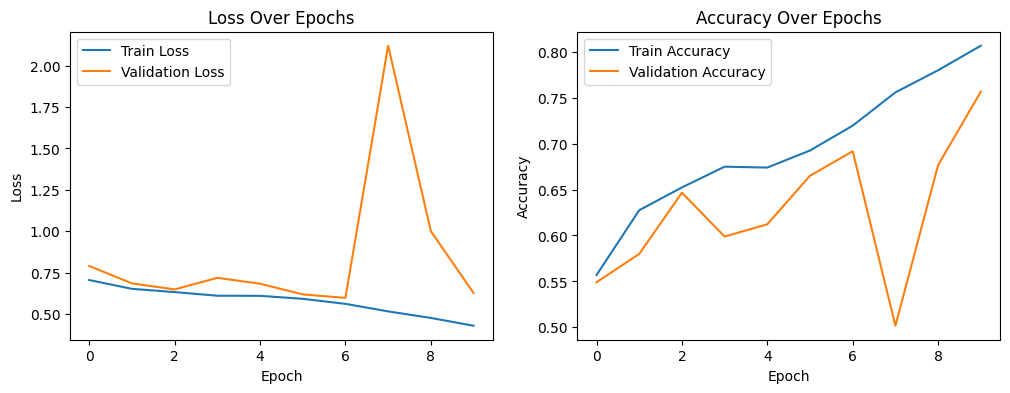

In [35]:
from  aiffel7 import history_graph
history_graph.plot_history(history_plainnet_50)

In [53]:
import tensorflow as tf

# 1. 모델 로드
plainnet_50.load_weights("plainnet_50.h5")
plainnet_50.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# 2. 모델 평가
# 테스트 데이터셋을 로드하고 전처리합니다. 예시에서는 ds_test를 사용하고 있습니다.
# ds_test는 테스트 데이터셋을 나타냅니다. 이미 전처리(리사이즈, 정규화 등)가 되어 있어야 합니다.
evaluation = plainnet_50.evaluate(ds_test)
print("평가 결과 (손실, 정확도):", evaluation)



73/73 [==============================] - 4s 41ms/step - loss: 0.5768 - accuracy: 0.7132
평가 결과 (손실, 정확도): [0.5767585039138794, 0.7132416367530823]


In [17]:

# ResNet 모델 생성
model = resnet_50  # ResNet-34 생성
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 콜백 설정
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "resnet_50.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 생성
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              monitor='val_loss',
                              verbose=1)

# 얼리 스탑핑 콜백 생성
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 모델 학습
history=model.fit(ds_train,
          validation_data=ds_validation,
          epochs=10,
          callbacks=[early_stop, cp_callback, tensorboard_callback])

Epoch 1/10
582/582 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.6080
Epoch 1: val_loss improved from inf to 1.05605, saving model to resnet_50.h5
582/582 [==============================] - 179s 254ms/step - loss: 0.6854 - accuracy: 0.6080 - val_loss: 1.0561 - val_accuracy: 0.5228
Epoch 2/10
582/582 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.6469
Epoch 2: val_loss improved from 1.05605 to 0.95692, saving model to resnet_50.h5
582/582 [==============================] - 143s 245ms/step - loss: 0.6246 - accuracy: 0.6469 - val_loss: 0.9569 - val_accuracy: 0.5748
Epoch 3/10
582/582 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.7275
Epoch 3: val_loss improved from 0.95692 to 0.70535, saving model to resnet_50.h5
582/582 [==============================] - 144s 247ms/step - loss: 0.5430 - accuracy: 0.7275 - val_loss: 0.7054 - val_accuracy: 0.6311
Epoch 4/10
582/582 [==============================] - ETA: 0s - loss

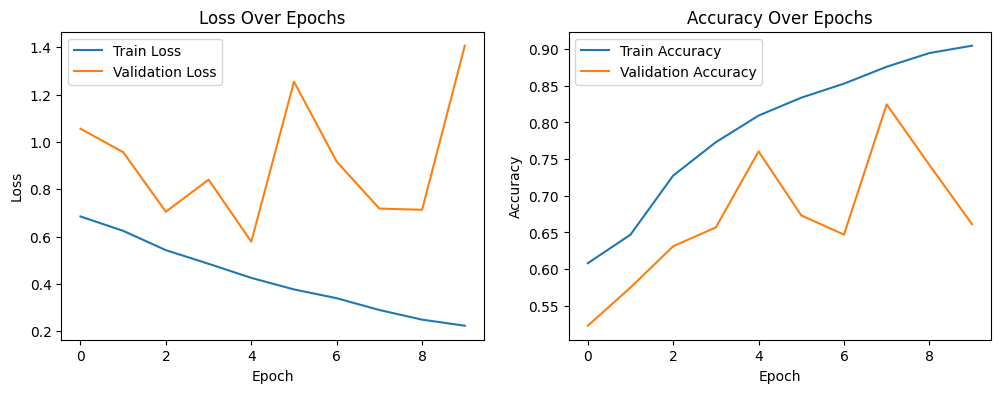

In [19]:
from aiffel7 import history_graph
history_graph.plot_history(history)

In [47]:
type(resnet_50)

keras.src.engine.functional.Functional

In [49]:
import tensorflow as tf

# 1. 모델 로드
resnet_50.load_weights("resnet_50.h5")
resnet_50.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# 2. 모델 평가
# 테스트 데이터셋을 로드하고 전처리합니다. 예시에서는 ds_test를 사용하고 있습니다.
# ds_test는 테스트 데이터셋을 나타냅니다. 이미 전처리(리사이즈, 정규화 등)가 되어 있어야 합니다.
evaluation = resnet_50.evaluate(ds_test)
print("평가 결과 (손실, 정확도):", evaluation)



73/73 [==============================] - 9s 72ms/step - loss: 0.5569 - accuracy: 0.7691
평가 결과 (손실, 정확도): [0.5569396018981934, 0.7691315412521362]


1/1 [==============================] - 0s 24ms/step


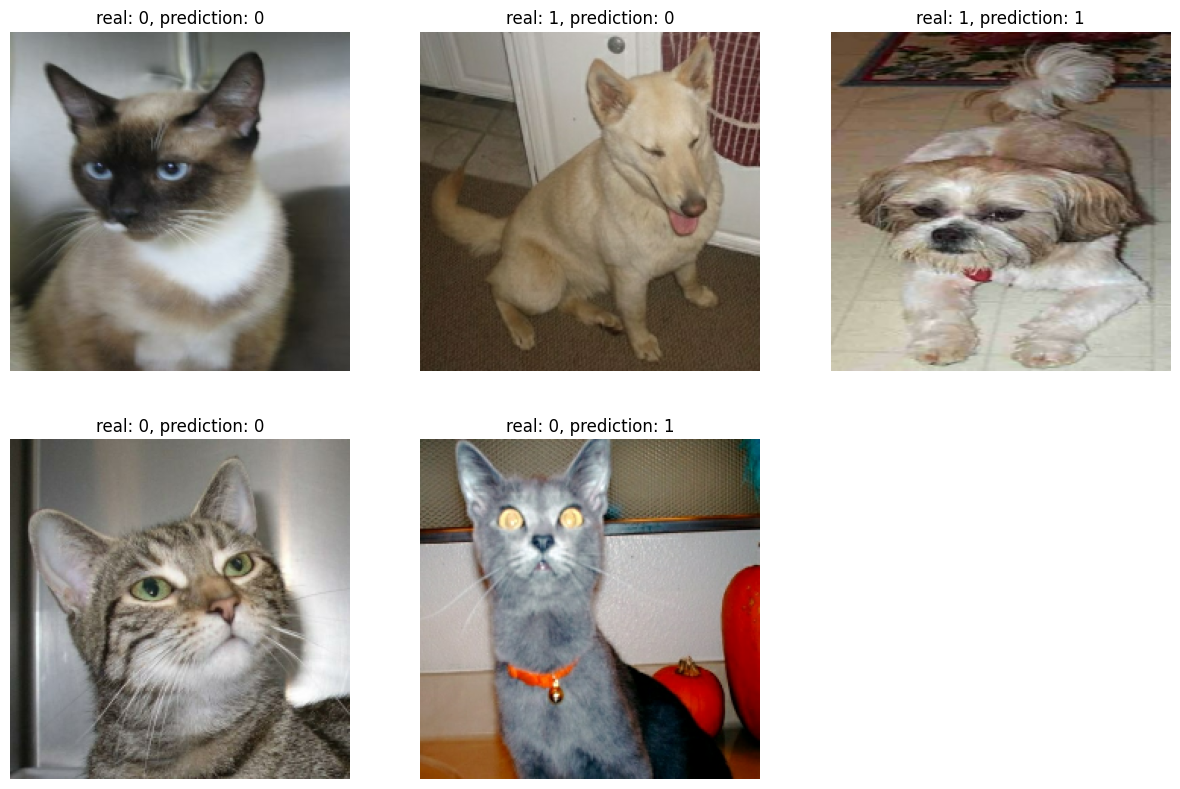

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# 테스트 데이터셋에서 이미지를 가져와 예측하고 시각화
def visualize_predictions(dataset, model, num_samples=5):
    plt.figure(figsize=(15, 15))

    # 첫 번째 배치에서 이미지와 라벨을 가져옵니다.
    for images, labels in dataset.take(1):
        # 모델을 사용하여 예측
        predictions = model.predict(images)
        predictions = np.argmax(predictions, axis=1)

        # 이미지와 예측 라벨을 시각화
        for i in range(num_samples):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(f"real: {labels[i].numpy()}, prediction: {predictions[i]}")
            plt.axis("off")

# 함수 호출
visualize_predictions(ds_test, resnet_50)

In [ ]:
# 3. 모델 예측
# 새로운 데이터에 대한 예측을 수행합니다.
# 예측하려는 이미지 또는 이미지 배치를 로드하고 동일한 전처리를 적용합니다.
# 예시에서는 테스트 데이터셋의 일부를 사용합니다.
import matplotlib.pyplot as plt
import numpy as np

# 테스트 데이터셋에서 이미지를 가져와 예측하고 시각화
def visualize_predictions(dataset, model, num_samples=5):
    plt.figure(figsize=(15, 15))

    # 첫 번째 배치에서 이미지와 라벨을 가져옵니다.
    for images, labels in dataset.take(1):
        # 모델을 사용하여 예측
        predictions = model.predict(images)
        predictions = np.argmax(predictions, axis=1)

        # 이미지와 예측 라벨을 시각화
        for i in range(num_samples):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"실제: {labels[i].numpy()}, 예측: {predictions[i]}")
            plt.axis("off")

# 함수 호출
visualize_predictions(ds_test, model)

In [20]:

# ResNet 모델 생성
model = resnet_34  # ResNet-34 생성
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 콜백 설정
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "resnet_34.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 생성
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              monitor='val_loss',
                              verbose=1)
# 얼리 스탑핑 콜백 생성
early_stop = EarlyStopping(monitor='val_loss', patience=10)
# 모델 학습
history_resnet_34=model.fit(ds_train,
          validation_data=ds_validation,
          epochs=10,
          callbacks=[early_stop, cp_callback, tensorboard_callback])

Epoch 1/10
582/582 [==============================] - ETA: 0s - loss: 0.7002 - accuracy: 0.6118
Epoch 1: val_loss improved from inf to 0.94647, saving model to resnet_34.h5
582/582 [==============================] - 82s 112ms/step - loss: 0.7002 - accuracy: 0.6118 - val_loss: 0.9465 - val_accuracy: 0.4996
Epoch 2/10
582/582 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.6870
Epoch 2: val_loss did not improve from 0.94647
582/582 [==============================] - 63s 108ms/step - loss: 0.5931 - accuracy: 0.6870 - val_loss: 1.0540 - val_accuracy: 0.4867
Epoch 3/10
582/582 [==============================] - ETA: 0s - loss: 0.5397 - accuracy: 0.7299
Epoch 3: val_loss did not improve from 0.94647
582/582 [==============================] - 62s 106ms/step - loss: 0.5397 - accuracy: 0.7299 - val_loss: 1.0944 - val_accuracy: 0.5692
Epoch 4/10
582/582 [==============================] - ETA: 0s - loss: 0.4873 - accuracy: 0.7657
Epoch 4: val_loss improved from 0.94647 to 

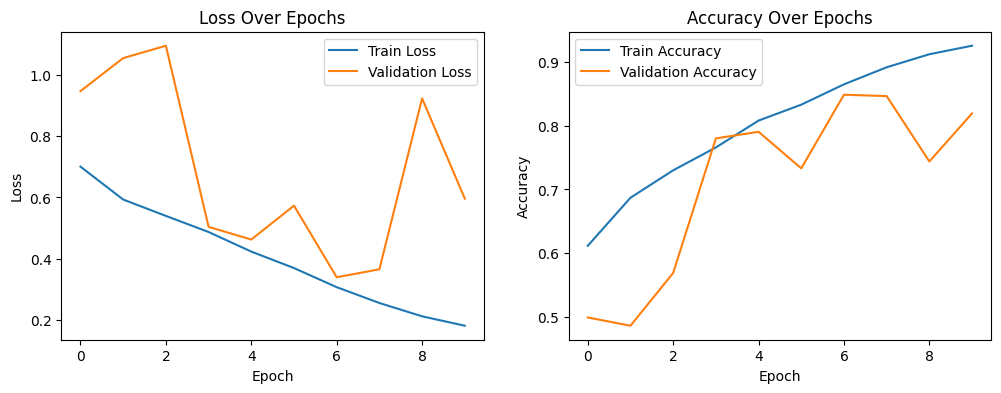

In [21]:
history_graph.plot_history(history_resnet_34)

In [54]:
import tensorflow as tf

# 1. 모델 로드
resnet_34.load_weights("resnet_34.h5")
resnet_34.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# 2. 모델 평가
# 테스트 데이터셋을 로드하고 전처리합니다. 예시에서는 ds_test를 사용하고 있습니다.
# ds_test는 테스트 데이터셋을 나타냅니다. 이미 전처리(리사이즈, 정규화 등)가 되어 있어야 합니다.
evaluation = resnet_34.evaluate(ds_test)
print("평가 결과 (손실, 정확도):", evaluation)

73/73 [==============================] - 3s 32ms/step - loss: 0.3226 - accuracy: 0.8581
평가 결과 (손실, 정확도): [0.32264721393585205, 0.8581255078315735]


In [29]:

# ResNet 모델 생성
model = plainnet_34  # ResNet-34 생성
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 콜백 설정
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "plainnet_34.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 생성
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              monitor='val_loss',
                              verbose=1)

# 얼리 스탑핑 콜백 생성
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 모델 학습
history_plainnet_34=model.fit(ds_train,
          validation_data=ds_validation,
          epochs=10,
          callbacks=[early_stop, tensorboard_callback])

Epoch 1/10
582/582 [==============================] - 74s 103ms/step - loss: 0.6952 - accuracy: 0.5400 - val_loss: 1.2123 - val_accuracy: 0.5232
Epoch 2/10
582/582 [==============================] - 60s 102ms/step - loss: 0.6761 - accuracy: 0.5574 - val_loss: 0.6922 - val_accuracy: 0.5301
Epoch 3/10
582/582 [==============================] - 60s 102ms/step - loss: 0.6718 - accuracy: 0.5666 - val_loss: 4.0223 - val_accuracy: 0.5241
Epoch 4/10
582/582 [==============================] - 60s 103ms/step - loss: 0.6675 - accuracy: 0.5815 - val_loss: 0.7738 - val_accuracy: 0.5671
Epoch 5/10
582/582 [==============================] - 60s 103ms/step - loss: 0.6568 - accuracy: 0.5976 - val_loss: 1.0319 - val_accuracy: 0.5305
Epoch 6/10
582/582 [==============================] - 59s 101ms/step - loss: 0.6318 - accuracy: 0.6419 - val_loss: 0.6712 - val_accuracy: 0.6242
Epoch 7/10
582/582 [==============================] - 60s 102ms/step - loss: 0.5982 - accuracy: 0.6788 - val_loss: 0.7100 - val_ac

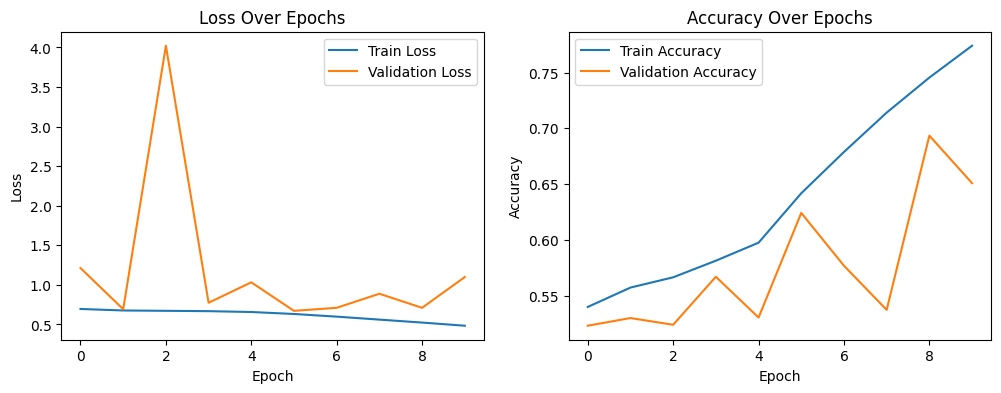

In [31]:
from aiffel7 import history_graph
history_graph.plot_history(history_plainnet_34)

In [55]:
import tensorflow as tf

# 1. 모델 로드
plainnet_34.load_weights("plainnet_34.h5")
plainnet_34.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# 2. 모델 평가
# 테스트 데이터셋을 로드하고 전처리합니다. 예시에서는 ds_test를 사용하고 있습니다.
# ds_test는 테스트 데이터셋을 나타냅니다. 이미 전처리(리사이즈, 정규화 등)가 되어 있어야 합니다.
evaluation = plainnet_34.evaluate(ds_test)
print("평가 결과 (손실, 정확도):", evaluation)

73/73 [==============================] - 3s 31ms/step - loss: 0.3725 - accuracy: 0.8663
평가 결과 (손실, 정확도): [0.3725017011165619, 0.8662940859794617]


In [ ]:
!pip install --upgrade aiffel7


  Attempting uninstall: aiffel7
    Found existing installation: aiffel7 0.4.2
    Uninstalling aiffel7-0.4.2:
      Successfully uninstalled aiffel7-0.4.2

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:

!pip install tensorflow_datasets


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 10.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 9.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.9/144.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.7/228.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 7.5 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21500 sha256=e870758a0ade8b08d49ee6ba2556a97b99376d9be247565155b1a8eba0e7dcd7
  Stored in directory: /root/

# 회고
Ablation Study 를 하는 방법을 이번 과정을 통해서 익혔고
잔차 연결을 하는 방법을 알게 되었다.
이번 결과는 예상외의 결과 가 나왔다. Resnet 34 가 50 보다 에폭이 같을때 더 좋은 결과 를 보여줬고
Plainnet 34 가 Resnet 34 보다 좋은 평가를 받았다. 34 와 50 끼리 비교를 했을 때 깊이가 깊은 34가 성능이 좋아야하는데 왜 그런지는 이유가 가지 않는다.
그리고 잔차 연결이 있는 Plainnet 의 성능이 왜 더 좋은 것인지도 이해가 가질 않는다.
그래서 그래프를 봤는데 그래프가 일관적이지 않았다.
이 현상은

- 1.과적합(Overfitting): 모델이 훈련 데이터에 너무 잘 맞추어져서 새로운 데이터에 대한 일반화 성능이 떨어지는 경우입니다. 이는 훈련 손실은 낮아지지만 검증 손실이 높아지는 현상으로 나타납니다.

    - 해결 방법: 데이터를 더 많이 수집하거나, 데이터 증강을 사용하고, 드롭아웃(Dropout) 또는 정규화 기법을 적용합니다.   
- 2.학습률(Learning Rate) 문제: 학습률이 너무 높거나 너무 낮은 경우 학습 과정이 제대로 진행되지 않을 수 있습니다.
    - 해결 방법: 학습률을 조정하거나 학습률 감소 스케줄러를 사용합니다.   
- 3.데이터의 문제: 데이터가 불균형하거나 잘못 라벨링된 경우, 모델의 학습에 영향을 미칠 수 있습니다.
    - 해결 방법: 데이터의 균형을 맞추고, 데이터 품질을 확인합니다.
- 4.모델 구조: 모델이 너무 단순하거나 복잡할 경우, 적절한 학습이 이루어지지 않을 수 있습니다.
    - 해결 방법: 모델 구조를 재검토하고 필요에 따라 레이어를 추가하거나 제거합니다.
- 5.배치 크기(Batch Size): 너무 크거나 작은 배치 크기는 학습 과정에 영향을 미칩니다.
    - 해결 방법: 배치 크기를 조정합니다.
- 6.초기화와 옵티마이저: 가중치 초기화 방법이나 사용하는 옵티마이저가 모델의 성능에 영향을 미칠 수 있습니다.
    - 해결 방법: 다른 초기화 방법이나 옵티마이저를 시도해봅니다.

이 6가지와 관련된 이슈로 파악이 된다. Ablation Study를 잘 할려면 중간 중간 그래프를 파악하여 그래프가 일관적인지 파악을 해야겠다는 생각이 들었다.

